# Data Preprocessing & Analysis

### Importing Packages

In [155]:
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import re
import string
from nltk.corpus import stopwords

import nltk
import spacy
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from joblib import dump, load

from sklearn.metrics import accuracy_score, classification_report

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Importing the Dataset

In [2]:
DATA_DIR = join('..', 'data', 'glue')

#### Train Dataset

In [3]:
train_full_df = pd.read_csv(join(DATA_DIR, 'train.tsv'), sep='\t')
train_full_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0
1,402555,536040,536041,How do I control my horny emotions?,How do you control your horniness?,1
2,360472,364011,490273,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0
3,150662,155721,7256,What can one do after MBBS?,What do i do after my MBBS ?,1
4,183004,279958,279959,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0


In [4]:
def remove_nulls(df):
    print(f"Initial dataframe has {len(df)} rows.")
    null_rows = df[df.isnull().values.any(1)]
    print(f"Dataframe has {len(null_rows)} null rows.")
    df = df.dropna(how='any')
    print(f"Dataframe has {len(df)} rows after removing null values.")
    return df

train_full_df = remove_nulls(train_full_df)

Initial dataframe has 363846 rows.
Dataframe has 0 null rows.
Dataframe has 363846 rows after removing null values.


In [5]:
train_full_df.shape

(363846, 6)

In [6]:
num_samples = len(train_full_df)
num_samples

363846

#### Test Dataset

In [7]:
test_df = pd.read_csv(join(DATA_DIR, 'dev.tsv'), sep='\t')
test_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,201359,303345,303346,Why are African-Americans so beautiful?,Why are hispanics so beautiful?,0
1,263843,69383,380476,I want to pursue PhD in Computer Science about...,I handle social media for a non-profit. Should...,0
2,172974,266948,175089,Is there a reason why we should travel alone?,What are some reasons to travel alone?,1
3,15329,29298,29299,Why are people so obsessed with having a girlf...,How can a single male have a child?,0
4,209794,314169,314170,What are some good baby girl names starting wi...,What are some good baby girl names starting wi...,0


In [8]:
test_df.shape

(40430, 6)

#### Train and Dev Dataset

In [9]:
train_df, dev_df = train_test_split(train_full_df, test_size=0.1, random_state=42)

In [10]:
len(train_df), len(dev_df)

(327461, 36385)

In [11]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,1
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,0
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,0
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,0
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,1


In [12]:
dev_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
215130,328831,455423,455424,Why do some people think that having a baby is...,Why is having a baby a blessing?,1
234600,41794,75402,75403,How vulnerable are paratroopers on their desce...,Are conventional paratroopers obsolete?,0
118406,184181,56834,281459,Examples of sole proprietorship? The,How are sole proprietorships started?,0
284746,61939,50127,69389,Why don't I get answers for some of my questio...,Why do some questions get more answers here in...,1
300683,352765,481723,13812,Do Kashmiris wants to join Pakistan?,Do the people of Kashmir want to join Pakistan...,0


### Splitting into X and y

In [13]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:, -1]

In [14]:
X_dev = dev_df.iloc[:,:-1]
y_dev = dev_df.iloc[:,-1]

In [15]:
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

# Exploratory Data Analysis (EDA)

### WordCloud

(-0.5, 359.5, 269.5, -0.5)

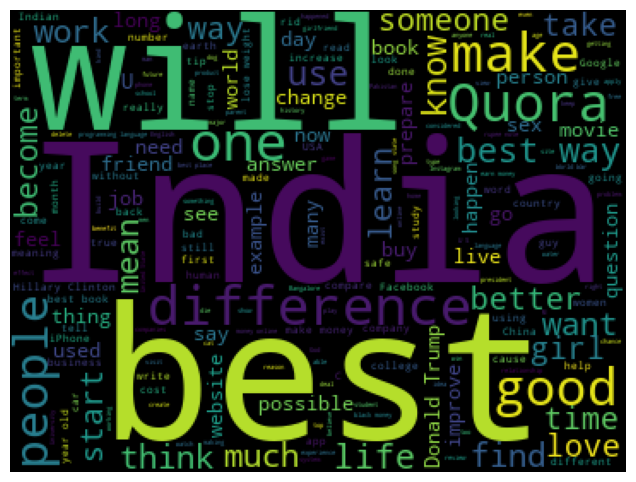

In [16]:
all_questions_concat = train_df['question1'].str.cat(sep=' ') + train_df['question2'].str.cat(sep=' ')

cloud = WordCloud(width=360, height=270).generate(all_questions_concat)
plt.figure(figsize=(10, 6))
plt.imshow(cloud)
plt.axis('off')

### Checking for Class Imbalance

In [16]:
pos_class_count = len(train_df[train_df['is_duplicate'] == 1])
neg_class_count = num_samples - pos_class_count

pos_percentage = (pos_class_count / num_samples) * 100
neg_percentage = (neg_class_count / num_samples) * 100

print(f'Number of question pairs classified as duplicate: {pos_class_count}, ({pos_percentage:.2f}%)')
print(f'Number of question pairs classified as not duplicate: {neg_class_count}, ({neg_percentage:.2f}%)')

Number of question pairs classified as duplicate: 121060, (33.27%)
Number of question pairs classified as not duplicate: 242786, (66.73%)


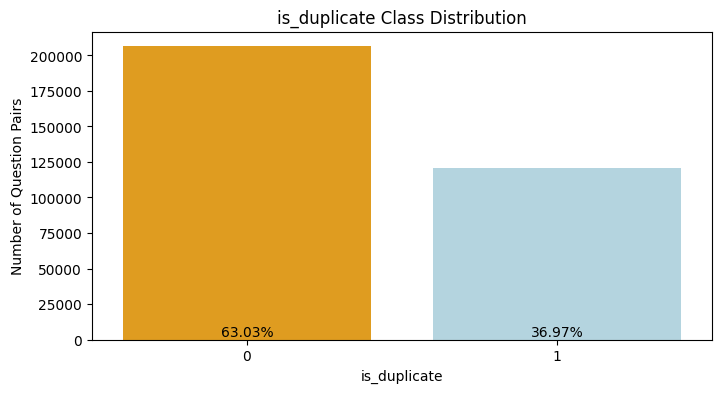

In [133]:
percentage_values = train_df['is_duplicate'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 4))
ax = sns.countplot(x='is_duplicate', data=train_df, palette=['orange', 'lightblue'])

for idx, value in enumerate(percentage_values):
    ax.text(idx, value + 0.1, f'{value:.2f}%', ha='center', va='bottom')  # Adjusted va parameter

plt.xlabel('is_duplicate')
plt.ylabel('Number of Question Pairs')
plt.title('is_duplicate Class Distribution')
plt.show()

### Checking for Duplicate Questions

In [18]:
question_ids = train_df['qid1'].to_list() + train_df['qid2'].to_list()
print(f"Total number of questions: {len(question_ids)}")

question_ids = pd.DataFrame(question_ids, columns=["qid"])
print(f"Unique questions: {len(question_ids['qid'].unique())}")

Total number of questions: 654922
Unique questions: 454160


In [19]:
question_counts = question_ids.value_counts()
question_counts

qid   
2559      133
4044       93
30782      93
2561       74
17978      59
         ... 
214911      1
214910      1
214909      1
214908      1
537933      1
Length: 454160, dtype: int64

In [20]:
# look at an example of a duplicate question
dup = train_df[(train_df['qid1'] == 2559) | (train_df['qid2'] == 2559)]
dup.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
357297,391318,127608,2559,What are the best laxatives to lose weight?,What are the best ways to lose weight?,0
342073,150557,236943,2559,What should be my diet plan for fat loss witho...,What are the best ways to lose weight?,0


In [21]:
# questions that appear more than once
dup_questions = question_counts[question_counts > 1]
dup_questions

qid   
2559      133
4044       93
30782      93
2561       74
17978      59
         ... 
273255      2
9567        2
187064      2
332388      2
49421       2
Length: 87200, dtype: int64

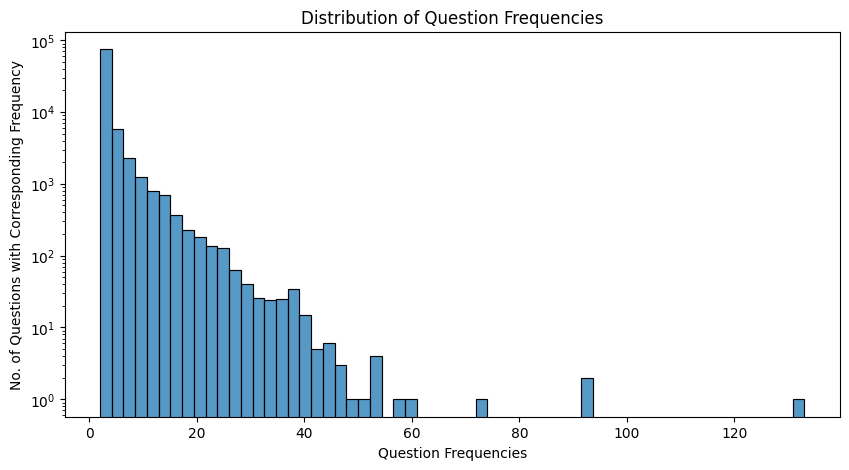

In [22]:
plt.figure(figsize=(10,5))
sns.histplot(data=dup_questions, bins=60)
plt.xlabel('Question Frequencies')
plt.ylabel('No. of Questions with Corresponding Frequency')
plt.yscale('log')
plt.title('Distribution of Question Frequencies')
plt.show()

### Checking for Duplicate Rows

In [23]:
pair_counts = train_df[['qid1', 'qid2']].groupby(['qid1', 'qid2']).count().reset_index()
has_duplicate_pairs = not (len(pair_counts) == num_samples)
print(f'There are {"" if has_duplicate_pairs else "no "}duplicate pairs.')

There are duplicate pairs.


### Data Preprocessing and Cleaning

In [ ]:
!python -m nltk.downloader stopwords

In [24]:
nlp = spacy.load("en_core_web_lg")

In [25]:
sw = set(stopwords.words("english"))

In [26]:
def preprocess(text, remove_stopwords=False):
    text = text.lower() # lower case
    text = re.sub('\s+\n+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text) # remove punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove special chars

    if remove_stopwords:
        text = ' '.join([word for word in text.split() if word not in sw])
        
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    
    return text

demo_qn = "What is the meaning of life? What is the most followed Instagram page? #@"
preprocess(demo_qn)

'what be the meaning of life what be the most follow instagram page'

In [27]:
X_train['cleaned_question1'] = X_train['question1'].apply(preprocess)
X_train['cleaned_question2'] = X_train['question2'].apply(preprocess)
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic be the most follow in quora,what topic on quora have the most follower
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what do it feel like to have sex with a relati...,be it possible to eat more than you weigh
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can I get back my good friend,how do I get back to my good friend as my lover
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,be there solar system that act like a double p...,as a navy seal do you feel as if people be afr...
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why be there only few magnet,why be there only few magnet


### Word Count Analysis


In [28]:
# find word counts of questions
X_train['question1_word_count'] = X_train['cleaned_question1'].apply(lambda x: len(word_tokenize(x)))
X_train['question2_word_count'] = X_train['cleaned_question2'].apply(lambda x: len(word_tokenize(x)))
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic be the most follow in quora,what topic on quora have the most follower,8,8
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what do it feel like to have sex with a relati...,be it possible to eat more than you weigh,13,9
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can I get back my good friend,how do I get back to my good friend as my lover,7,12
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,be there solar system that act like a double p...,as a navy seal do you feel as if people be afr...,10,20
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why be there only few magnet,why be there only few magnet,6,6


Min word count for question 1: 0
Min word count for question 2: 0
Max word count for question 1: 126
Max word count for question 2: 249


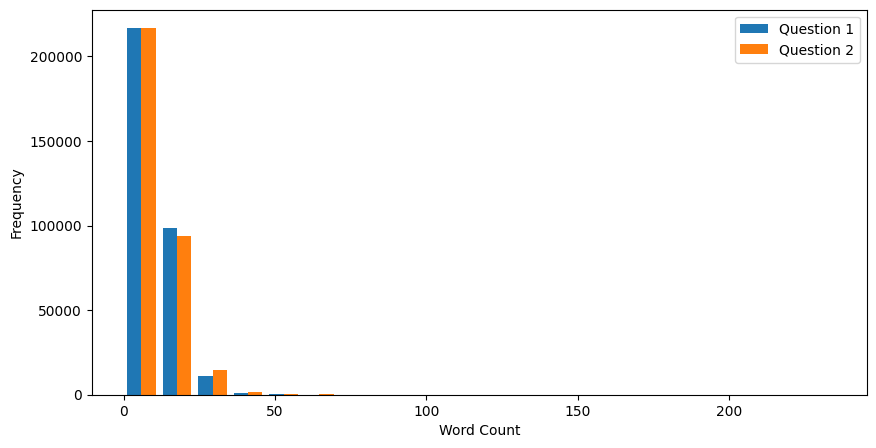

In [28]:
print(f"Min word count for question 1: {X_train['question1_word_count'].min()}")
print(f"Min word count for question 2: {X_train['question2_word_count'].min()}")

print(f"Max word count for question 1: {X_train['question1_word_count'].max()}")
print(f"Max word count for question 2: {X_train['question2_word_count'].max()}")

plt.figure(figsize=(10, 5))
plt.hist([X_train['question1_word_count'], X_train['question2_word_count']], bins=20, label=['Question 1', 'Question 2'], range=(0, 235))
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

In [29]:
X_train['question1_word_count'].describe()

count    327461.000000
mean         10.984603
std           5.473985
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         126.000000
Name: question1_word_count, dtype: float64

In [30]:
X_train['question2_word_count'].describe()

count    327461.000000
mean         11.230815
std           6.358647
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         249.000000
Name: question2_word_count, dtype: float64

In [31]:
X_train[(X_train['question1_word_count'] == 0) | (X_train['question2_word_count'] == 0)].head(2)

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count
220206,144343,228468,228469,What is the psychological explanation to the e...,ماذا علي ان افعل لكي اشعر بالسعادة و الرضى ؟,what be the psychological explanation to the e...,,16,0
117965,96725,161071,161072,?,"Who are Moses, Noah and Exodus?",,who be moses noah and exodus,0,6


In [32]:
word_count_bins = 20
hist, bin_edges = np.histogram(X_train['question1_word_count'], bins=word_count_bins)

bin_with_highest_freq = bin_edges[np.argmax(hist)]
bin_with_lowest_freq = bin_edges[np.argmin(hist)]
print(f"Word count with the highest frequency: {bin_with_highest_freq:1f}")
print(f"Word count with the lowest frequency: {bin_with_lowest_freq:1f}")

Word count with the highest frequency: 6.300000
Word count with the lowest frequency: 81.900000


### Word Frequency Analysis


In [33]:
word_frequency = X_train['cleaned_question1'].str.cat(sep=' ').split() + X_train['cleaned_question2'].str.cat(sep=' ').split()
word_freq_dict = pd.Series(word_frequency).value_counts()

In [34]:
num_words = len(word_freq_dict)
print(f"Number of unique words/tokens: {num_words}")

Number of unique words/tokens: 86174


In [35]:
word_freq_dict.head(10)  # 10 most common words

be      412492
the     305811
what    263053
do      206610
I       193060
how     178513
a       170855
to      166651
in      159232
of      129376
dtype: int64

In [36]:
word_freq_dict.tail(10) # least common words

udid             1
idfv             1
leoncio          1
deriada          1
4872             1
girlfiend        1
viraldiskcom     1
teeevo           1
disengagement    1
himhate          1
dtype: int64

# Feature Extraction

### Jaccard Similarity

In [29]:
def calculate_common_word_proportion(question1, question2):
    tokens1 = list(set(word_tokenize(question1)))
    tokens2 = list(set(word_tokenize(question2)))

    # intersection of the token sets
    common_tokens = np.intersect1d(tokens1, tokens2)
    total_tokens = np.union1d(tokens1, tokens2)

    # proportion of common words (Jaccard similarity)
    proportion = (len(common_tokens) / len(total_tokens)) if not len(total_tokens) == 0 else 0

    return proportion

### With Stopwords

In [30]:
X_train['common_word_proportion'] = X_train.apply(lambda row: calculate_common_word_proportion(row['cleaned_question1'], row['cleaned_question2']), axis=1)
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic be the most follow in quora,what topic on quora have the most follower,8,8,0.333333
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what do it feel like to have sex with a relati...,be it possible to eat more than you weigh,13,9,0.100000
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can I get back my good friend,how do I get back to my good friend as my lover,7,12,0.500000
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,be there solar system that act like a double p...,as a navy seal do you feel as if people be afr...,10,20,0.086957
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why be there only few magnet,why be there only few magnet,6,6,1.000000


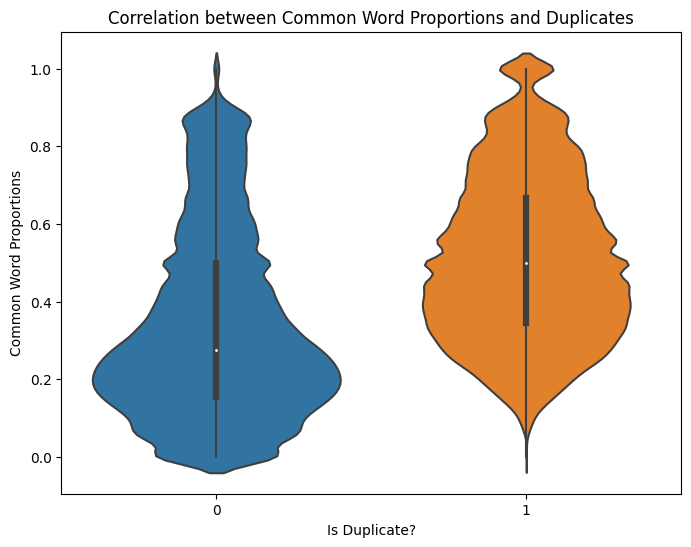

In [31]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='common_word_proportion', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('Common Word Proportions')
plt.title('Correlation between Common Word Proportions and Duplicates')
plt.show()

There is not much of a correlation between the word proportions and whether the question pair is a duplicate or not. This could be due to the presence of stopwords.

In [32]:
correlation_coefficient = X_train['common_word_proportion'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.3434455502892533


### Jaccard Similarity (Excluding Stopwords)

In [33]:
X_train['no_stops_question1'] = X_train['question1'].apply(lambda x: preprocess(x, remove_stopwords=True))
X_train['no_stops_question2'] = X_train['question2'].apply(lambda x: preprocess(x, remove_stopwords=True))

In [34]:
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic be the most follow in quora,what topic on quora have the most follower,8,8,0.333333,topic follow quora,topic quora follower
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what do it feel like to have sex with a relati...,be it possible to eat more than you weigh,13,9,0.100000,feel like sex relatively chubby female,possible eat weigh
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can I get back my good friend,how do I get back to my good friend as my lover,7,12,0.500000,get back good friend,get back good friend lover
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,be there solar system that act like a double p...,as a navy seal do you feel as if people be afr...,10,20,0.086957,solar system act like double pendulum,navy seal feel people afraid know seal
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why be there only few magnet,why be there only few magnet,6,6,1.000000,magnet,magnet


In [35]:
X_train['common_word_proportion_no_stops'] = X_train.apply(lambda row: calculate_common_word_proportion(row['no_stops_question1'], row['no_stops_question2']), axis=1)
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic be the most follow in quora,what topic on quora have the most follower,8,8,0.333333,topic follow quora,topic quora follower,0.5
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what do it feel like to have sex with a relati...,be it possible to eat more than you weigh,13,9,0.100000,feel like sex relatively chubby female,possible eat weigh,0.0
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can I get back my good friend,how do I get back to my good friend as my lover,7,12,0.500000,get back good friend,get back good friend lover,0.8
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,be there solar system that act like a double p...,as a navy seal do you feel as if people be afr...,10,20,0.086957,solar system act like double pendulum,navy seal feel people afraid know seal,0.0
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why be there only few magnet,why be there only few magnet,6,6,1.000000,magnet,magnet,1.0


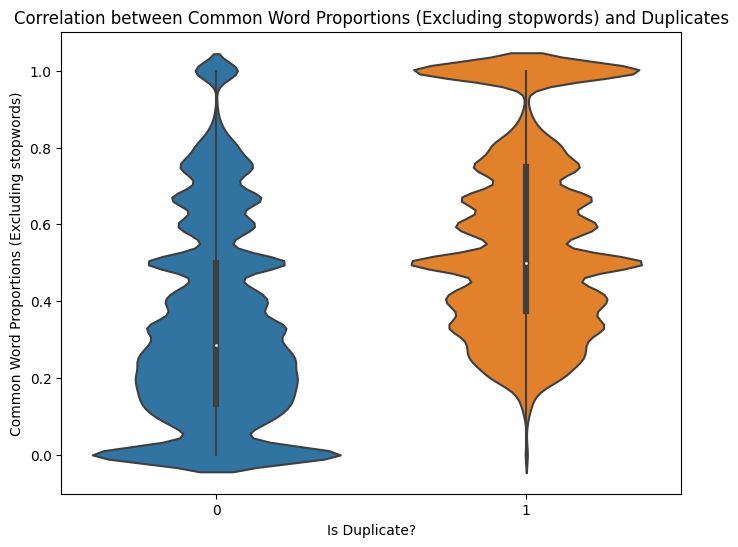

In [36]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='common_word_proportion_no_stops', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('Common Word Proportions (Excluding stopwords)')
plt.title('Correlation between Common Word Proportions (Excluding stopwords) and Duplicates')
plt.show()

It can be observed from the plot above that there is a small correlation between the proportion of common words (excluding stopwords) and whether the question pair is a duplicate or not.

If the proportion of common words is low (close to zero), them there is a high probability that it is not a duplicate.

In this example, we treat all words equally. We can use TF-IDF to weigh each word so that if an uncommon word appears in both questions, it can be mean there is a higher chance of the questions being duplicates.

In [37]:
correlation_coefficient = X_train['common_word_proportion_no_stops'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.40214334904839355


### TF-IDF Similarity

In [38]:
q1 = X_train['no_stops_question1']
q2 = X_train['no_stops_question2']
q1_concat_q2 = pd.concat([q1, q2])

In [39]:
tfidf_vectorizer = load('tfidf_vectorizer.joblib')

In [40]:
tfidf_matrix = tfidf_vectorizer.transform(q1_concat_q2)

In [42]:
vectorizer = TfidfVectorizer()
tfidf_vectorizer = vectorizer.fit(q1_concat_q2)
tfidf_matrix = tfidf_vectorizer.transform(q1_concat_q2)

['tfidf_vectorizer.joblib']

In [ ]:
dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

In [42]:
tfidf_matrix.shape

(654922, 87438)

In [43]:
def tfidf_word_share(doc1_idx, doc2_idx, tfidf_matrix):
    tfidf_doc1 = tfidf_matrix[doc1_idx]
    tfidf_doc2 = tfidf_matrix[doc2_idx]
    cosine_sim = cosine_similarity(tfidf_doc1, tfidf_doc2)
    similarity_score = cosine_sim[0][0]
    return similarity_score

In [44]:
X_train['tfidf_similarity'] = [tfidf_word_share(i, i + len(X_train), tfidf_matrix) for i in range(len(X_train))]

In [45]:
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic be the most follow in quora,what topic on quora have the most follower,8,8,0.333333,topic follow quora,topic quora follower,0.5,0.589496
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what do it feel like to have sex with a relati...,be it possible to eat more than you weigh,13,9,0.100000,feel like sex relatively chubby female,possible eat weigh,0.0,0.000000
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can I get back my good friend,how do I get back to my good friend as my lover,7,12,0.500000,get back good friend,get back good friend lover,0.8,0.723994
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,be there solar system that act like a double p...,as a navy seal do you feel as if people be afr...,10,20,0.086957,solar system act like double pendulum,navy seal feel people afraid know seal,0.0,0.000000
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why be there only few magnet,why be there only few magnet,6,6,1.000000,magnet,magnet,1.0,1.000000


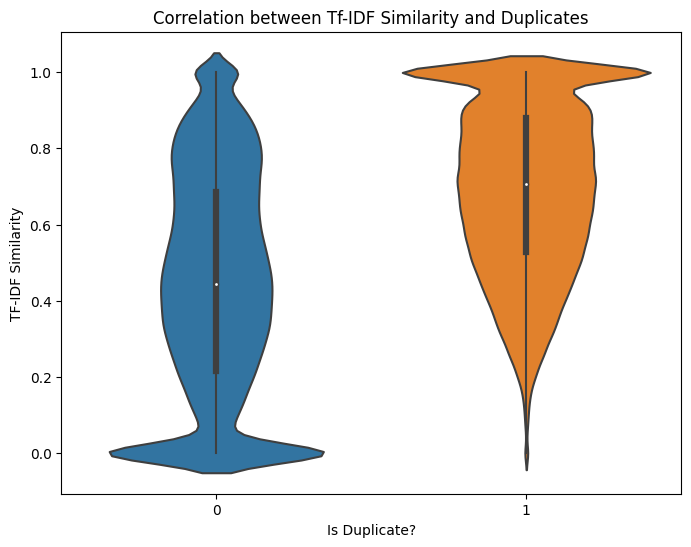

In [46]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='tfidf_similarity', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('TF-IDF Similarity')
plt.title('Correlation between Tf-IDF Similarity and Duplicates')
plt.show()

In [47]:
correlation_coefficient = X_train['tfidf_similarity'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.4043937014698942


### Difference in Question Character Count

In [48]:
X_train['char_count_diff'] = abs(X_train['question1'].str.len() - X_train['question2'].str.len())
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic be the most follow in quora,what topic on quora have the most follower,8,8,0.333333,topic follow quora,topic quora follower,0.5,0.589496,1
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what do it feel like to have sex with a relati...,be it possible to eat more than you weigh,13,9,0.100000,feel like sex relatively chubby female,possible eat weigh,0.0,0.000000,25
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can I get back my good friend,how do I get back to my good friend as my lover,7,12,0.500000,get back good friend,get back good friend lover,0.8,0.723994,18
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,be there solar system that act like a double p...,as a navy seal do you feel as if people be afr...,10,20,0.086957,solar system act like double pendulum,navy seal feel people afraid know seal,0.0,0.000000,28
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why be there only few magnet,why be there only few magnet,6,6,1.000000,magnet,magnet,1.0,1.000000,1


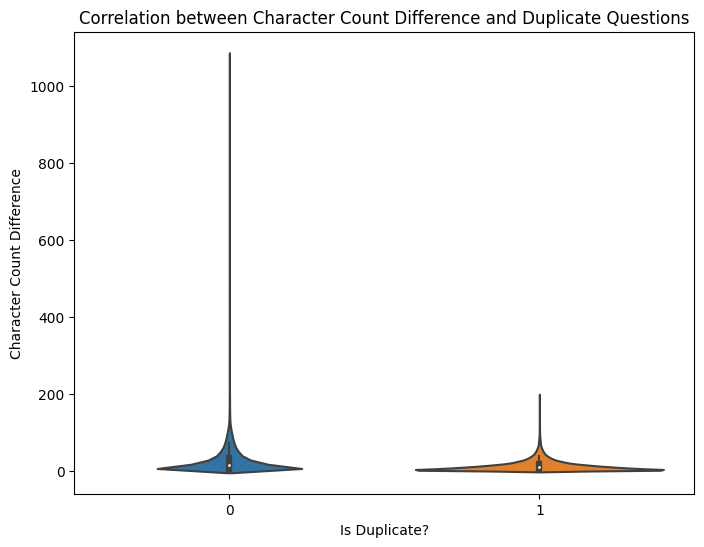

In [49]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='char_count_diff', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('Character Count Difference')
plt.title('Correlation between Character Count Difference and Duplicate Questions')
plt.show()

In [50]:
correlation_coefficient = X_train['char_count_diff'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: -0.21050559749472827


### Difference in Question Length

Check if there is a correlation between question having the same lengths and the question pair being a duplicate

There doesn't seem to be a correlation, so the `question_length_diff` feature may not be too useful.

In [51]:
X_train['question_length_diff'] = abs(X_train['question1_word_count'] - X_train['question2_word_count'])
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic be the most follow in quora,what topic on quora have the most follower,8,8,0.333333,topic follow quora,topic quora follower,0.5,0.589496,1,0
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what do it feel like to have sex with a relati...,be it possible to eat more than you weigh,13,9,0.100000,feel like sex relatively chubby female,possible eat weigh,0.0,0.000000,25,4
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can I get back my good friend,how do I get back to my good friend as my lover,7,12,0.500000,get back good friend,get back good friend lover,0.8,0.723994,18,5
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,be there solar system that act like a double p...,as a navy seal do you feel as if people be afr...,10,20,0.086957,solar system act like double pendulum,navy seal feel people afraid know seal,0.0,0.000000,28,10
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why be there only few magnet,why be there only few magnet,6,6,1.000000,magnet,magnet,1.0,1.000000,1,0


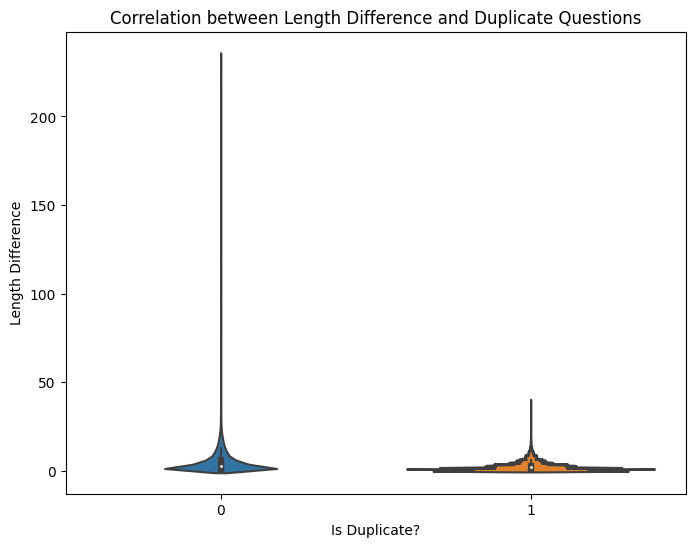

In [52]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='question_length_diff', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('Length Difference')
plt.title('Correlation between Length Difference and Duplicate Questions')
plt.show()

There is not much correlation, this feature might not be too important.

In [53]:
correlation_coefficient = X_train['question_length_diff'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: -0.20248297255970757


### Selecting Numerical Features

In [54]:
X_train_filtered = X_train[['question1_word_count', 'question2_word_count', 'common_word_proportion', 'common_word_proportion_no_stops', 'tfidf_similarity', 'char_count_diff', 'question_length_diff']]
X_train_filtered.head()

,question1_word_count,question2_word_count,common_word_proportion,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
80519,8,8,0.333333,0.5,0.589496,1,0
349125,13,9,0.100000,0.0,0.000000,25,4
126605,7,12,0.500000,0.8,0.723994,18,5
6008,10,20,0.086957,0.0,0.000000,28,10
292788,6,6,1.000000,1.0,1.000000,1,0


### Correlation Analysis

In [55]:
for col in X_train_filtered.columns:
    print(f"Correlation between is_duplicate and {col}: {X_train[col].corr(y_train):.4f}")

Correlation between is_duplicate and question1_word_count: -0.1538
Correlation between is_duplicate and question2_word_count: -0.1594
Correlation between is_duplicate and common_word_proportion: 0.3434
Correlation between is_duplicate and common_word_proportion_no_stops: 0.4021
Correlation between is_duplicate and tfidf_similarity: 0.4044
Correlation between is_duplicate and char_count_diff: -0.2105
Correlation between is_duplicate and question_length_diff: -0.2025


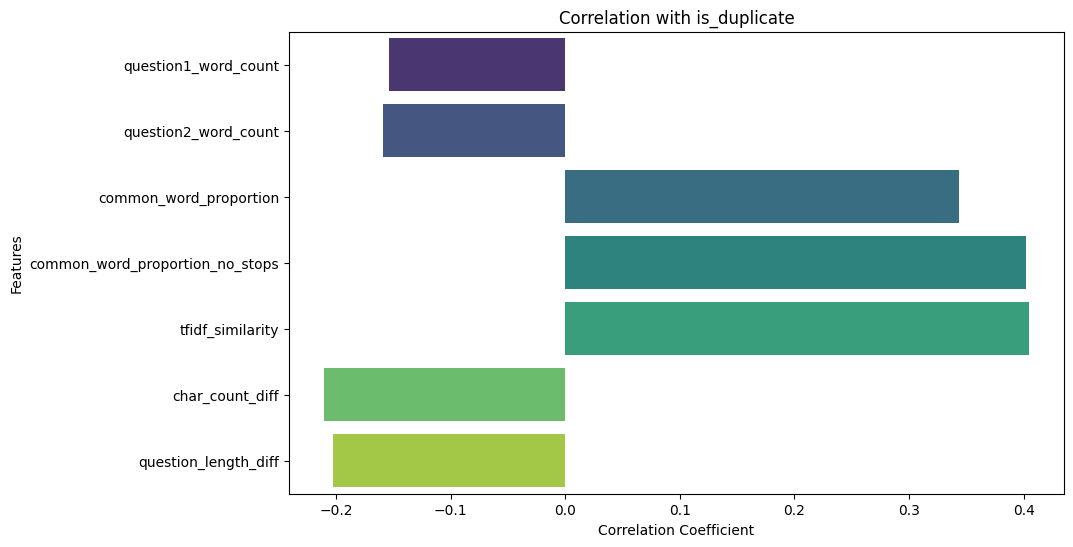

In [124]:
correlations = X_train_filtered.corrwith(y_train)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette="viridis")

plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.title("Correlation with is_duplicate")

plt.show()

# Training Simple Classifiers

In [57]:
from joblib import load
tfidf_vectorizer = load('tfidf_vectorizer.joblib')

def transform_question_pairs(val_test):
    df = val_test.copy()

    df = remove_nulls(df)

    df['cleaned_question1'] = df['question1'].apply(preprocess)
    df['cleaned_question2'] = df['question2'].apply(preprocess)

    df['question1_word_count'] = df['cleaned_question1'].apply(lambda x: len(word_tokenize(x)))
    df['question2_word_count'] = df['cleaned_question2'].apply(lambda x: len(word_tokenize(x)))

    df['common_word_proportion'] = df.apply(lambda row: calculate_common_word_proportion(row['cleaned_question1'], row['cleaned_question2']), axis=1)

    df['no_stops_question1'] = df['question1'].apply(lambda x: preprocess(x, remove_stopwords=True))
    df['no_stops_question2'] = df['question2'].apply(lambda x: preprocess(x, remove_stopwords=True))

    df['common_word_proportion_no_stops'] = df.apply(lambda row: calculate_common_word_proportion(row['no_stops_question1'], row['no_stops_question2']), axis=1)

    q1 = df['no_stops_question1']
    q2 = df['no_stops_question2']
    q1_concat_q2 = pd.concat([q1, q2])

    tfidf_matrix_df = tfidf_vectorizer.transform(q1_concat_q2)

    df['tfidf_similarity'] = [tfidf_word_share(i, i + len(df), tfidf_matrix_df) for i in range(len(df))]

    df['char_count_diff'] = abs(df['question1'].str.len() - df['question2'].str.len())
    df['question_length_diff'] = abs(df['question1_word_count'] - df['question2_word_count'])

    return df

In [58]:
X_dev = transform_question_pairs(X_dev)
X_dev_filtered = X_dev[['question1_word_count', 'question2_word_count', 'common_word_proportion', 'common_word_proportion_no_stops', 'tfidf_similarity', 'char_count_diff', 'question_length_diff']]
X_dev_filtered.head()

Initial dataframe has 36385 rows.
Dataframe has 0 null rows.
Dataframe has 36385 rows after removing null values.


,question1_word_count,question2_word_count,common_word_proportion,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
215130,12,7,0.545455,0.500000,0.892326,26,5
234600,16,4,0.133333,0.142857,0.314281,51,12
118406,5,5,0.250000,0.500000,0.873520,1,0
284746,13,10,0.437500,0.666667,0.829533,5,3
300683,6,12,0.384615,0.250000,0.339612,25,6


In [59]:
X_test = transform_question_pairs(X_test)
X_test_filtered = X_test[['question1_word_count', 'question2_word_count', 'common_word_proportion', 'common_word_proportion_no_stops', 'tfidf_similarity', 'char_count_diff', 'question_length_diff']]
X_test_filtered.head()

Initial dataframe has 40430 rows.
Dataframe has 0 null rows.
Dataframe has 40430 rows after removing null values.


,question1_word_count,question2_word_count,common_word_proportion,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
0,5,5,0.666667,0.333333,0.315623,8,0
1,18,25,0.187500,0.047619,0.216397,30,7
2,9,7,0.333333,1.000000,1.000000,7,2
3,9,8,0.142857,0.000000,0.000000,27,1
4,10,12,0.833333,0.833333,1.000000,5,2


## SVM Without Scaling

#### Without CV

In [ ]:
# initialize SVM model
svm_model = SVC(C=1.0, kernel='rbf')

svm_model.fit(X_train_filtered, y_train)

#### Train Accuracy

In [ ]:
svm_train_predictions = svm_model.predict(X_train_filtered)

#### Saving Train Results

In [124]:
X_train_results = X_train.copy()
X_train_results['is_duplicate'] = y_train
X_train_results['prediction'] = svm_train_predictions
X_train_results.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,is_duplicate,prediction
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic is the most followed in quora,what topic on quora has the most followers,8,8,0.333333,topic followed quora,topic quora followers,0.5,0.564432,1,0,1,0
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what does it feel like to have sex with a rela...,is it possible to eat more than you weigh,13,9,0.100000,feel like sex relatively chubby female,possible eat weigh,0.0,0.000000,25,4,0,0
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can i get back my best friend,how do i get back to my best friend as my lover,7,12,0.500000,get back best friend,get back best friend lover,0.8,0.730278,18,5,0,1
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,are there solar systems that act like a double...,as a navy seal do you feel as if people are af...,10,20,0.086957,solar systems act like double pendulum,navy seal feel people afraid know seal,0.0,0.000000,28,10,0,0
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why are there only few magnets,why is there only few magnets,6,6,0.714286,magnets,magnets,1.0,1.000000,1,0,1,1


In [125]:
X_train_results.to_csv('svm_train_results.csv')

In [126]:
svm_train_accuracy = accuracy_score(y_train, svm_train_predictions)
print(f"SVM Train Accuracy: {svm_train_accuracy * 100:.2f}%")
print(classification_report(y_train, svm_train_predictions))

SVM Train Accuracy: 68.29%
              precision    recall  f1-score   support

           0       0.71      0.83      0.77    206401
           1       0.60      0.43      0.50    121060

    accuracy                           0.68    327461
   macro avg       0.66      0.63      0.63    327461
weighted avg       0.67      0.68      0.67    327461



#### Validation Accuracy

In [77]:
# predict on validation set
svm_val_predictions = svm_model.predict(X_dev_filtered)

#### Saving Validation Results

In [81]:
X_dev_results = X_dev.copy()
X_dev_results['is_duplicate'] = y_dev
X_dev_results['prediction'] = svm_val_predictions
X_dev_results.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,is_duplicate,prediction
215130,328831,455423,455424,Why do some people think that having a baby is...,Why is having a baby a blessing?,why do some people think that having a baby is...,why is having a baby a blessing,12,7,0.545455,people think baby blessing,baby blessing,0.500,0.895849,26,5,1,1
234600,41794,75402,75403,How vulnerable are paratroopers on their desce...,Are conventional paratroopers obsolete?,how vulnerable are paratroopers on their desce...,are conventional paratroopers obsolete,16,4,0.125000,vulnerable paratroopers descent fired fire back,conventional paratroopers obsolete,0.125,0.352165,51,12,0,0
118406,184181,56834,281459,Examples of sole proprietorship? The,How are sole proprietorships started?,examples of sole proprietorship the,how are sole proprietorships started,5,5,0.111111,examples sole proprietorship,sole proprietorships started,0.200,0.336050,1,0,0,0
284746,61939,50127,69389,Why don't I get answers for some of my questio...,Why do some questions get more answers here in...,why don t i get answers for some of my questio...,why do some questions get more answers here in...,13,10,0.352941,get answers questions quora,questions get answers quora,1.000,1.000000,5,3,1,1
300683,352765,481723,13812,Do Kashmiris wants to join Pakistan?,Do the people of Kashmir want to join Pakistan...,do kashmiris wants to join pakistan,do the people of kashmir want to join pakistan...,6,12,0.285714,kashmiris wants join pakistan,people kashmir want join pakistan india,0.250,0.364696,25,6,0,0


In [82]:
X_dev_results.to_csv('svm_dev_results.csv')

In [83]:
# evaluate metrics on validation set
svm_val_accuracy = accuracy_score(y_dev, svm_val_predictions)
print(f"SVM Validation Accuracy: {svm_val_accuracy * 100:.2f}%")
print(classification_report(y_dev, svm_val_predictions))

SVM Validation Accuracy: 68.29%
              precision    recall  f1-score   support

           0       0.71      0.83      0.77     23067
           1       0.59      0.43      0.50     13318

    accuracy                           0.68     36385
   macro avg       0.65      0.63      0.63     36385
weighted avg       0.67      0.68      0.67     36385



#### Test Accuracy

In [84]:
# predict on test set
svm_test_predictions = svm_model.predict(X_test_filtered)

#### Saving Test Results

In [85]:
X_test_results = X_test.copy()
X_test_results['is_duplicate'] = y_test
X_test_results['prediction'] = svm_test_predictions
X_test_results.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,is_duplicate,prediction
0,201359,303345,303346,Why are African-Americans so beautiful?,Why are hispanics so beautiful?,why are african americans so beautiful,why are hispanics so beautiful,6,5,0.571429,african americans beautiful,hispanics beautiful,0.250000,0.290955,8,1,0,0
1,263843,69383,380476,I want to pursue PhD in Computer Science about...,I handle social media for a non-profit. Should...,i want to pursue phd in computer science about...,i handle social media for a non profit should...,19,26,0.142857,want pursue phd computer science social networ...,handle social media non profit start going soc...,0.045455,0.219512,30,7,0,0
2,172974,266948,175089,Is there a reason why we should travel alone?,What are some reasons to travel alone?,is there a reason why we should travel alone,what are some reasons to travel alone,9,7,0.142857,reason travel alone,reasons travel alone,0.500000,0.668023,7,2,1,0
3,15329,29298,29299,Why are people so obsessed with having a girlf...,How can a single male have a child?,why are people so obsessed with having a girlf...,how can a single male have a child,10,8,0.062500,people obsessed girlfriend boyfriend,single male child,0.000000,0.000000,27,2,0,0
4,209794,314169,314170,What are some good baby girl names starting wi...,What are some good baby girl names starting wi...,what are some good baby girl names starting wi...,what are some good baby girl names starting wi...,10,12,0.833333,good baby girl names starting,good baby girl names starting h,0.833333,1.000000,5,2,0,1


In [86]:
X_test_results.to_csv('svm_test_results.csv')

In [101]:
# evaluate metrics on test set
svm_test_accuracy = accuracy_score(y_test, svm_test_predictions)
print(f"SVM Test Accuracy: {svm_test_accuracy * 100:.2f}%")
print(classification_report(y_test, svm_test_predictions))

SVM Test Accuracy: 67.92%
              precision    recall  f1-score   support

           0       0.71      0.83      0.77     25545
           1       0.59      0.42      0.49     14885

    accuracy                           0.68     40430
   macro avg       0.65      0.63      0.63     40430
weighted avg       0.67      0.68      0.66     40430



### Saving and Loading Model

In [16]:
import joblib
from datetime import datetime

def save_model(model, model_type=None):
    today = datetime.now().strftime('%Y-%m-%d')
    model_filepath = f'{model_type}_{today}.pkl'
    joblib.dump(model, model_filepath)

def load_model(model_filepath):
    return joblib.load(model_filepath)

In [104]:
save_model(svm_model, model_type='svm')

In [103]:
# load saved model
svm_model_filepath = 'C:/Users/eugen/Downloads/finalised models/01-simple_classifiers/svm_2023-11-02.pkl'
svm_model = joblib.load(svm_model_filepath)
svm_model

SVC()

## Logistic Regression Without Scaling

#### With CV

In [ ]:
lr_model = LogisticRegression()

param_grid = {
    'C': [0.1, 0.5, 0.85, 1],
    'solver': ['saga', 'newton-cg', 'newton-cholesky'],
    'max_iter': [500, 1000, 5000, 10000, 15000]
}

lr_grid_search = GridSearchCV(lr_model, param_grid, scoring='accuracy')

lr_grid_search.fit(X_train_filtered, y_train)

best_lr_model = lr_grid_search.best_estimator_

In [69]:
lr_grid_search.best_params_

{'C': 1, 'max_iter': 500, 'solver': 'newton-cg'}

In [65]:
save_model(best_lr_model, model_type='lr_cv')

In [70]:
# load saved model
# lr_model_filepath = 'C:/Users/eugen/Downloads/finalised models/01-simple_classifiers/lr_cv_2023-11-02.pkl'
lr_model_filepath = 'lr_cv_2023-11-14.pkl'
best_lr_model = joblib.load(lr_model_filepath)
best_lr_model

LogisticRegression(C=1, max_iter=500, solver='newton-cg')

#### Model Weights

In [71]:
best_lr_model.coef_

array([[-0.00986011, -0.01572086,  0.64649046,  0.52504411,  2.26922515,
        -0.00603065,  0.00529399]])

In [72]:
best_lr_model.intercept_

array([-1.98040859])

#### Train Accuracy

In [73]:
lr_train_predictions = best_lr_model.predict(X_train_filtered)

#### Saving Train Results

In [121]:
X_train_results = X_train.copy()
X_train_results['is_duplicate'] = y_train
X_train_results['prediction'] = lr_train_predictions
X_train_results.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,is_duplicate,prediction
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic is the most followed in quora,what topic on quora has the most followers,8,8,0.333333,topic followed quora,topic quora followers,0.5,0.564432,1,0,1,0
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what does it feel like to have sex with a rela...,is it possible to eat more than you weigh,13,9,0.100000,feel like sex relatively chubby female,possible eat weigh,0.0,0.000000,25,4,0,0
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can i get back my best friend,how do i get back to my best friend as my lover,7,12,0.500000,get back best friend,get back best friend lover,0.8,0.730278,18,5,0,1
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,are there solar systems that act like a double...,as a navy seal do you feel as if people are af...,10,20,0.086957,solar systems act like double pendulum,navy seal feel people afraid know seal,0.0,0.000000,28,10,0,0
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why are there only few magnets,why is there only few magnets,6,6,0.714286,magnets,magnets,1.0,1.000000,1,0,1,1


In [122]:
X_train_results.to_csv('lr_train_results.csv')

In [74]:
lr_train_accuracy = accuracy_score(y_train, lr_train_predictions)
print(f"Logistic Regression Train Accuracy: {lr_train_accuracy * 100:.2f}%")
print(classification_report(y_train, lr_train_predictions))

Logistic Regression Train Accuracy: 66.26%
              precision    recall  f1-score   support

           0       0.71      0.78      0.75    206401
           1       0.55      0.45      0.50    121060

    accuracy                           0.66    327461
   macro avg       0.63      0.62      0.62    327461
weighted avg       0.65      0.66      0.65    327461



#### Validation Accuracy

In [75]:
lr_val_predictions = best_lr_model.predict(X_dev_filtered)

#### Saving Validation Results

In [96]:
X_dev_results = X_dev.copy()
X_dev_results['is_duplicate'] = y_dev
X_dev_results['prediction'] = lr_val_predictions
X_dev_results.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,is_duplicate,prediction
215130,328831,455423,455424,Why do some people think that having a baby is...,Why is having a baby a blessing?,why do some people think that having a baby is...,why is having a baby a blessing,12,7,0.545455,people think baby blessing,baby blessing,0.500,0.895849,26,5,1,1
234600,41794,75402,75403,How vulnerable are paratroopers on their desce...,Are conventional paratroopers obsolete?,how vulnerable are paratroopers on their desce...,are conventional paratroopers obsolete,16,4,0.125000,vulnerable paratroopers descent fired fire back,conventional paratroopers obsolete,0.125,0.352165,51,12,0,0
118406,184181,56834,281459,Examples of sole proprietorship? The,How are sole proprietorships started?,examples of sole proprietorship the,how are sole proprietorships started,5,5,0.111111,examples sole proprietorship,sole proprietorships started,0.200,0.336050,1,0,0,0
284746,61939,50127,69389,Why don't I get answers for some of my questio...,Why do some questions get more answers here in...,why don t i get answers for some of my questio...,why do some questions get more answers here in...,13,10,0.352941,get answers questions quora,questions get answers quora,1.000,1.000000,5,3,1,1
300683,352765,481723,13812,Do Kashmiris wants to join Pakistan?,Do the people of Kashmir want to join Pakistan...,do kashmiris wants to join pakistan,do the people of kashmir want to join pakistan...,6,12,0.285714,kashmiris wants join pakistan,people kashmir want join pakistan india,0.250,0.364696,25,6,0,0


In [97]:
X_dev_results.to_csv('lr_dev_results.csv')

In [76]:
# evalute metrics on validation set
lr_val_accuracy = accuracy_score(y_dev, lr_val_predictions)
print(f"Logistic Regression Validation Accuracy: {lr_val_accuracy * 100:.2f}%")
print(classification_report(y_dev, lr_val_predictions))

Logistic Regression Validation Accuracy: 66.08%
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     23067
           1       0.54      0.46      0.50     13318

    accuracy                           0.66     36385
   macro avg       0.63      0.62      0.62     36385
weighted avg       0.65      0.66      0.65     36385



#### Test Accuracy

In [75]:
lr_test_predictions = best_lr_model.predict(X_test_filtered)

#### Saving Test Results

In [101]:
X_test_results = X_test.copy()
X_test_results['is_duplicate'] = y_test
X_test_results['prediction'] = lr_test_predictions
X_test_results.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,is_duplicate,prediction
0,201359,303345,303346,Why are African-Americans so beautiful?,Why are hispanics so beautiful?,why are african americans so beautiful,why are hispanics so beautiful,6,5,0.571429,african americans beautiful,hispanics beautiful,0.250000,0.290955,8,1,0,0
1,263843,69383,380476,I want to pursue PhD in Computer Science about...,I handle social media for a non-profit. Should...,i want to pursue phd in computer science about...,i handle social media for a non profit should...,19,26,0.142857,want pursue phd computer science social networ...,handle social media non profit start going soc...,0.045455,0.219512,30,7,0,0
2,172974,266948,175089,Is there a reason why we should travel alone?,What are some reasons to travel alone?,is there a reason why we should travel alone,what are some reasons to travel alone,9,7,0.142857,reason travel alone,reasons travel alone,0.500000,0.668023,7,2,1,0
3,15329,29298,29299,Why are people so obsessed with having a girlf...,How can a single male have a child?,why are people so obsessed with having a girlf...,how can a single male have a child,10,8,0.062500,people obsessed girlfriend boyfriend,single male child,0.000000,0.000000,27,2,0,0
4,209794,314169,314170,What are some good baby girl names starting wi...,What are some good baby girl names starting wi...,what are some good baby girl names starting wi...,what are some good baby girl names starting wi...,10,12,0.833333,good baby girl names starting,good baby girl names starting h,0.833333,1.000000,5,2,0,1


In [102]:
X_test_results.to_csv('lr_test_results.csv')

In [76]:
# evaluate metrics on test set
lr_test_accuracy = accuracy_score(y_test, lr_test_predictions)
print(f"Logistic Regression Test Accuracy: {lr_test_accuracy * 100:.2f}%")
print(classification_report(y_test, lr_test_predictions))

Logistic Regression Test Accuracy: 65.89%
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     25545
           1       0.54      0.45      0.49     14885

    accuracy                           0.66     40430
   macro avg       0.63      0.62      0.62     40430
weighted avg       0.65      0.66      0.65     40430



## $k$-NN Without Scaling

#### With CV

In [106]:
knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [100, 250, 500],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

# 5, 7, 9, 12, 15, 20, 

knn_grid_search = GridSearchCV(knn_model, param_grid, scoring='accuracy')

knn_grid_search.fit(X_train_filtered, y_train)

best_knn_model = knn_grid_search.best_estimator_

In [107]:
knn_grid_search.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 100, 'weights': 'distance'}

In [90]:
save_model(best_knn_model, model_type='knn_cv')

In [108]:
best_knn_model

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=100, weights='distance')

In [ ]:
# load saved model
knn_model_filepath = 'C:/Users/eugen/Downloads/finalised models/01-simple_classifiers/knn_cv_2023-11-02.pkl'
best_knn_model = joblib.load(knn_model_filepath)
best_knn_model

#### Train Accuracy

In [109]:
knn_train_predictions = best_knn_model.predict(X_train_filtered)

#### Saving Train Results

In [85]:
X_train_results = X_train.copy()
X_train_results['is_duplicate'] = y_train
X_train_results['prediction'] = knn_train_predictions
X_train_results.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,is_duplicate,prediction
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic be the most follow in quora,what topic on quora have the most follower,8,8,0.333333,topic follow quora,topic quora follower,0.5,0.589496,1,0,1,1
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what do it feel like to have sex with a relati...,be it possible to eat more than you weigh,13,9,0.100000,feel like sex relatively chubby female,possible eat weigh,0.0,0.000000,25,4,0,0
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can I get back my good friend,how do I get back to my good friend as my lover,7,12,0.500000,get back good friend,get back good friend lover,0.8,0.723994,18,5,0,0
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,be there solar system that act like a double p...,as a navy seal do you feel as if people be afr...,10,20,0.086957,solar system act like double pendulum,navy seal feel people afraid know seal,0.0,0.000000,28,10,0,0
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why be there only few magnet,why be there only few magnet,6,6,1.000000,magnet,magnet,1.0,1.000000,1,0,1,1


In [129]:
X_train_results.to_csv('knn_train_results.csv')

In [110]:
knn_train_accuracy = accuracy_score(y_train, knn_train_predictions)
print(f"kNN Train Accuracy: {knn_train_accuracy * 100:.2f}%")
print(classification_report(y_train, knn_train_predictions))

kNN Train Accuracy: 99.00%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    206401
           1       0.98      0.99      0.99    121060

    accuracy                           0.99    327461
   macro avg       0.99      0.99      0.99    327461
weighted avg       0.99      0.99      0.99    327461



#### Validation Accuracy

In [111]:
knn_val_predictions = best_knn_model.predict(X_dev_filtered)

#### Saving Validation Results

In [113]:
X_dev_results = X_dev.copy()
X_dev_results['is_duplicate'] = y_dev
X_dev_results['prediction'] = knn_val_predictions
X_dev_results.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,is_duplicate,prediction
215130,328831,455423,455424,Why do some people think that having a baby is...,Why is having a baby a blessing?,why do some people think that having a baby is...,why is having a baby a blessing,12,7,0.545455,people think baby blessing,baby blessing,0.500,0.895849,26,5,1,1
234600,41794,75402,75403,How vulnerable are paratroopers on their desce...,Are conventional paratroopers obsolete?,how vulnerable are paratroopers on their desce...,are conventional paratroopers obsolete,16,4,0.125000,vulnerable paratroopers descent fired fire back,conventional paratroopers obsolete,0.125,0.352165,51,12,0,0
118406,184181,56834,281459,Examples of sole proprietorship? The,How are sole proprietorships started?,examples of sole proprietorship the,how are sole proprietorships started,5,5,0.111111,examples sole proprietorship,sole proprietorships started,0.200,0.336050,1,0,0,0
284746,61939,50127,69389,Why don't I get answers for some of my questio...,Why do some questions get more answers here in...,why don t i get answers for some of my questio...,why do some questions get more answers here in...,13,10,0.352941,get answers questions quora,questions get answers quora,1.000,1.000000,5,3,1,0
300683,352765,481723,13812,Do Kashmiris wants to join Pakistan?,Do the people of Kashmir want to join Pakistan...,do kashmiris wants to join pakistan,do the people of kashmir want to join pakistan...,6,12,0.285714,kashmiris wants join pakistan,people kashmir want join pakistan india,0.250,0.364696,25,6,0,0


In [114]:
X_dev_results.to_csv('knn_dev_results.csv')

In [112]:
knn_val_accuracy = accuracy_score(y_dev, knn_val_predictions)
print(f"kNN Validation Accuracy: {knn_val_accuracy * 100:.2f}%")
print(classification_report(y_dev, knn_val_predictions))

kNN Validation Accuracy: 69.51%
              precision    recall  f1-score   support

           0       0.73      0.83      0.78     23067
           1       0.61      0.46      0.52     13318

    accuracy                           0.70     36385
   macro avg       0.67      0.65      0.65     36385
weighted avg       0.68      0.70      0.68     36385



#### Test Accuracy

In [95]:
knn_test_predictions = best_knn_model.predict(X_test_filtered)

#### Saving Test Results

In [116]:
X_test_results = X_test.copy()
X_test_results['is_duplicate'] = y_test
X_test_results['prediction'] = knn_test_predictions
X_test_results.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,is_duplicate,prediction
0,201359,303345,303346,Why are African-Americans so beautiful?,Why are hispanics so beautiful?,why are african americans so beautiful,why are hispanics so beautiful,6,5,0.571429,african americans beautiful,hispanics beautiful,0.250000,0.290955,8,1,0,1
1,263843,69383,380476,I want to pursue PhD in Computer Science about...,I handle social media for a non-profit. Should...,i want to pursue phd in computer science about...,i handle social media for a non profit should...,19,26,0.142857,want pursue phd computer science social networ...,handle social media non profit start going soc...,0.045455,0.219512,30,7,0,0
2,172974,266948,175089,Is there a reason why we should travel alone?,What are some reasons to travel alone?,is there a reason why we should travel alone,what are some reasons to travel alone,9,7,0.142857,reason travel alone,reasons travel alone,0.500000,0.668023,7,2,1,1
3,15329,29298,29299,Why are people so obsessed with having a girlf...,How can a single male have a child?,why are people so obsessed with having a girlf...,how can a single male have a child,10,8,0.062500,people obsessed girlfriend boyfriend,single male child,0.000000,0.000000,27,2,0,0
4,209794,314169,314170,What are some good baby girl names starting wi...,What are some good baby girl names starting wi...,what are some good baby girl names starting wi...,what are some good baby girl names starting wi...,10,12,0.833333,good baby girl names starting,good baby girl names starting h,0.833333,1.000000,5,2,0,1


In [117]:
X_test_results.to_csv('knn_test_results.csv')

In [96]:
knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)
print(f"kNN Test Accuracy: {knn_test_accuracy * 100:.2f}%")
print(classification_report(y_test, knn_test_predictions))

kNN Test Accuracy: 69.25%
              precision    recall  f1-score   support

           0       0.74      0.79      0.76     25545
           1       0.59      0.52      0.56     14885

    accuracy                           0.69     40430
   macro avg       0.67      0.66      0.66     40430
weighted avg       0.69      0.69      0.69     40430



## Preloading Processed Question Pairs 

In [115]:
X_train = pd.read_csv('X_train_processed.csv', index_col=0)
X_dev = pd.read_csv('X_dev_processed.csv', index_col=0)
X_test = pd.read_csv('X_test_processed.csv', index_col=0)

In [116]:
X_train_filtered = X_train[['question1_word_count', 'question2_word_count', 'common_word_proportion', 'common_word_proportion_no_stops', 'tfidf_similarity', 'char_count_diff', 'question_length_diff']]
X_train_filtered.head()

,question1_word_count,question2_word_count,common_word_proportion,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
80519,8,8,0.333333,0.5,0.589496,1,0
349125,13,9,0.100000,0.0,0.000000,25,4
126605,7,12,0.500000,0.8,0.723994,18,5
6008,10,20,0.086957,0.0,0.000000,28,10
292788,6,6,1.000000,1.0,1.000000,1,0


In [117]:
X_dev_filtered = X_dev[['question1_word_count', 'question2_word_count', 'common_word_proportion', 'common_word_proportion_no_stops', 'tfidf_similarity', 'char_count_diff', 'question_length_diff']]
X_dev_filtered.head()

,question1_word_count,question2_word_count,common_word_proportion,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
215130,12,7,0.545455,0.500000,0.892326,26,5
234600,16,4,0.133333,0.142857,0.314281,51,12
118406,5,5,0.250000,0.500000,0.873520,1,0
284746,13,10,0.437500,0.666667,0.829533,5,3
300683,6,12,0.384615,0.250000,0.339612,25,6


In [118]:
X_test_filtered = X_test[['question1_word_count', 'question2_word_count', 'common_word_proportion', 'common_word_proportion_no_stops', 'tfidf_similarity', 'char_count_diff', 'question_length_diff']]
X_test_filtered.head()

,question1_word_count,question2_word_count,common_word_proportion,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
0,5,5,0.666667,0.333333,0.315623,8,0
1,18,25,0.187500,0.047619,0.216397,30,7
2,9,7,0.333333,1.000000,1.000000,7,2
3,9,8,0.142857,0.000000,0.000000,27,1
4,10,12,0.833333,0.833333,1.000000,5,2


In [119]:
y_train = train_df.iloc[:, -1]
y_dev = dev_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

# Testing Out Scaling and PCA

This section aims to further improve the performance of the models from before by considering methods learnt in lecture about dimensionality reduction and feature engineering.

## PCA Data Preparation

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)

n_components = 4
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_train_pca.head()

,PC1,PC2,PC3,PC4
0,-1.026910,-0.799708,-0.012234,-0.072210
1,1.931652,-1.814111,-0.385051,0.324301
2,-1.083927,0.881775,0.766098,-0.339269
3,2.895267,-0.857489,0.140867,-1.144443
4,-3.596349,1.382856,0.419868,0.013379


In [25]:
evr = pca.explained_variance_ratio_
evr

array([0.54501189, 0.22178867, 0.10642784, 0.071057  ])

In [26]:
evr.sum()

0.9442854014828812

### Visualising PCs

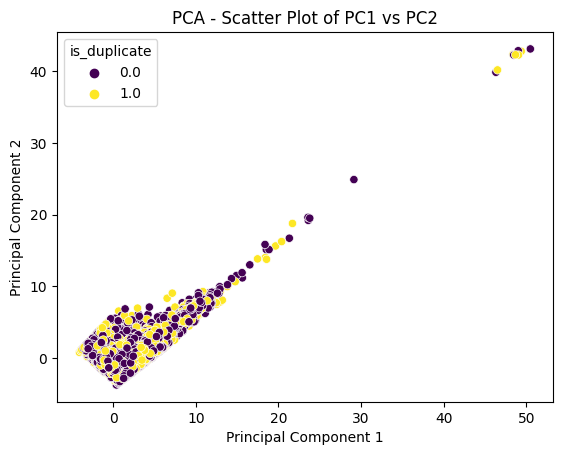

In [27]:
first_two = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2'])
first_two['is_duplicate'] = y_train

# Scatter plot
sns.scatterplot(x='PC1', y='PC2', hue='is_duplicate', data=first_two, palette='viridis')
plt.title('PCA - Scatter Plot of PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Dev and Test Sets

In [28]:
X_dev_scaled = scaler.transform(X_dev_filtered)

X_dev_pca = pca.transform(X_dev_scaled)
X_dev_pca = pd.DataFrame(X_dev_pca, columns=[f'PC{i+1}' for i in range(X_dev_pca.shape[1])])
X_dev_pca.head()

,PC1,PC2,PC3,PC4
0,-0.790551,0.816663,0.410021,0.823159
1,2.241320,-0.348056,0.745620,1.820612
2,-1.581254,-0.912751,0.717135,0.164938
3,-1.098196,0.647883,-0.288869,0.369146
4,0.600796,-0.581805,0.743775,-0.580288


In [29]:
X_test_scaled = scaler.transform(X_test_filtered)

X_test_pca = pca.transform(X_test_scaled)
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
X_test_pca.head()

,PC1,PC2,PC3,PC4
0,-1.116485,-1.167329,0.241577,-0.198556
1,2.802607,0.293084,-1.253091,-1.014198
2,-2.073599,0.747576,0.575615,0.525127
3,1.389288,-2.231970,-0.056393,-0.021278
4,-2.347650,1.666675,-0.091438,-0.240427


### Scaled Datasets

In [30]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_filtered.columns)
X_dev_scaled = pd.DataFrame(X_dev_scaled, columns=X_dev_filtered.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_filtered.columns)

## PCA ($k$-NN)

In [133]:
knn_pca_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [20, 35, 45], # removed 75 (overfitting)
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

# try 100, 200 neighbors and remove 20, 35

knn_pca_grid_search = GridSearchCV(knn_pca_model, param_grid, scoring='accuracy')

knn_pca_grid_search.fit(X_train_pca, y_train)

best_knn_pca_model = knn_pca_grid_search.best_estimator_

In [134]:
best_knn_pca_model

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=75, weights='distance')

In [135]:
knn_pca_train_predictions = best_knn_pca_model.predict(X_train_pca)

In [136]:
knn_pca_train_accuracy = accuracy_score(y_train, knn_pca_train_predictions)
print(f"kNN (with PCA) Train Accuracy: {knn_pca_train_accuracy * 100:.2f}%")
print(classification_report(y_train, knn_pca_train_predictions))

kNN (with PCA) Train Accuracy: 99.00%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    206401
           1       0.98      0.99      0.99    121060

    accuracy                           0.99    327461
   macro avg       0.99      0.99      0.99    327461
weighted avg       0.99      0.99      0.99    327461



In [138]:
knn_pca_val_predictions = best_knn_pca_model.predict(X_dev_pca_df)

In [139]:
knn_pca_val_accuracy = accuracy_score(y_dev, knn_pca_val_predictions)
print(f"kNN (with PCA) Validation Accuracy: {knn_pca_val_accuracy * 100:.2f}%")
print(classification_report(y_dev, knn_pca_val_predictions))

kNN (with PCA) Validation Accuracy: 71.01%
              precision    recall  f1-score   support

           0       0.77      0.78      0.77     23067
           1       0.61      0.59      0.60     13318

    accuracy                           0.71     36385
   macro avg       0.69      0.68      0.69     36385
weighted avg       0.71      0.71      0.71     36385



In [141]:
knn_pca_test_predictions = best_knn_pca_model.predict(X_test_pca_df)

In [142]:
knn_pca_test_accuracy = accuracy_score(y_test, knn_pca_test_predictions)
print(f"kNN (with PCA) Test Accuracy: {knn_pca_test_accuracy * 100:.2f}%")
print(classification_report(y_test, knn_pca_test_predictions))

kNN (with PCA) Test Accuracy: 70.88%
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     25545
           1       0.61      0.59      0.60     14885

    accuracy                           0.71     40430
   macro avg       0.69      0.68      0.69     40430
weighted avg       0.71      0.71      0.71     40430



## Scaled Features without PCA ($k$-NN)

In [36]:
knn_scaled_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [20, 35, 50, 75],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

# try 100, 200 neighbors and remove 20, 35

knn_scaled_grid_search = GridSearchCV(knn_scaled_model, param_grid, scoring='accuracy')

knn_scaled_grid_search.fit(X_train_scaled, y_train)

best_knn_scaled_model = knn_scaled_grid_search.best_estimator_

In [37]:
best_knn_scaled_model

KNeighborsClassifier(n_neighbors=75)

In [39]:
save_model(best_knn_scaled_model, model_type='knn_cv_scaled')

In [40]:
knn_scaled_train_predictions = best_knn_scaled_model.predict(X_train_scaled)

In [41]:
knn_scaled_train_accuracy = accuracy_score(y_train, knn_scaled_train_predictions)
print(f"kNN (Scaled) Train Accuracy: {knn_scaled_train_accuracy * 100:.2f}%")
print(classification_report(y_train, knn_scaled_train_predictions))

kNN (Scaled) Train Accuracy: 73.42%
              precision    recall  f1-score   support

           0       0.79      0.79      0.79    206401
           1       0.64      0.64      0.64    121060

    accuracy                           0.73    327461
   macro avg       0.71      0.71      0.71    327461
weighted avg       0.73      0.73      0.73    327461



In [42]:
knn_scaled_val_predictions = best_knn_scaled_model.predict(X_dev_scaled)

In [43]:
knn_scaled_val_accuracy = accuracy_score(y_dev, knn_scaled_val_predictions)
print(f"kNN (Scaled) Validation Accuracy: {knn_scaled_val_accuracy * 100:.2f}%")
print(classification_report(y_dev, knn_scaled_val_predictions))

kNN (Scaled) Validation Accuracy: 72.22%
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     23067
           1       0.62      0.63      0.62     13318

    accuracy                           0.72     36385
   macro avg       0.70      0.70      0.70     36385
weighted avg       0.72      0.72      0.72     36385



In [44]:
knn_scaled_test_predictions = best_knn_scaled_model.predict(X_test_scaled)

In [45]:
knn_scaled_test_accuracy = accuracy_score(y_test, knn_scaled_test_predictions)
print(f"kNN (Scaled) Test Accuracy: {knn_scaled_test_accuracy * 100:.2f}%")
print(classification_report(y_test, knn_scaled_test_predictions))

kNN (Scaled) Test Accuracy: 71.66%
              precision    recall  f1-score   support

           0       0.78      0.77      0.78     25545
           1       0.61      0.62      0.62     14885

    accuracy                           0.72     40430
   macro avg       0.70      0.70      0.70     40430
weighted avg       0.72      0.72      0.72     40430



In [65]:
knn_test_results = X_test.copy()
knn_test_results['is_duplicate'] = y_test
knn_test_results['prediction'] = knn_scaled_test_predictions
knn_test_results.to_csv('knn_scaled_results.csv')

## PCA (Logistic Regression)

In [ ]:
lr_pca_model = LogisticRegression()

param_grid = {
    'C': [0.1, 0.5, 1, 1.5, 2],
    'solver': ['saga', 'newton-cg', 'newton-cholesky'],
    'max_iter': [500, 1000, 1500, 2000]
}

lr_pca_grid_search = GridSearchCV(lr_pca_model, param_grid, scoring='accuracy')

lr_pca_grid_search.fit(X_train_pca, y_train)

best_lr_pca_model = lr_pca_grid_search.best_estimator_

In [76]:
best_lr_pca_model

LogisticRegression(C=0.1, max_iter=1500, solver='saga')

In [203]:
save_model(best_lr_pca_model, model_type='lr_cv_pca')

In [38]:
best_lr_pca_model = load_model("lr_cv_pca_2023-11-17.pkl")

In [77]:
for i, w in enumerate(best_lr_pca_model.coef_[0]):
    print(f"{X_train_pca.columns[i]}'s weight: {w}")

PC1's weight: -0.47635711132429154
PC2's weight: 0.2935962355081649
PC3's weight: 0.141881134300887
PC4's weight: 0.11273918213584064


In [78]:
lr_pca_train_predictions = best_lr_pca_model.predict(X_train_pca)

In [79]:
lr_pca_train_accuracy = accuracy_score(y_train, lr_pca_train_predictions)
print(f"Logistic Regression (With PCA) Train Accuracy: {lr_pca_train_accuracy * 100:.2f}%")
print(classification_report(y_train, lr_pca_train_predictions))

Logistic Regression (With PCA) Train Accuracy: 65.72%
              precision    recall  f1-score   support

           0       0.70      0.79      0.74    206401
           1       0.55      0.43      0.48    121060

    accuracy                           0.66    327461
   macro avg       0.62      0.61      0.61    327461
weighted avg       0.64      0.66      0.65    327461



In [80]:
lr_pca_val_predictions = best_lr_pca_model.predict(X_dev_pca)

In [81]:
lr_pca_val_accuracy = accuracy_score(y_dev, lr_pca_val_predictions)
print(f"Logistic Regression (With PCA) Validation Accuracy: {lr_pca_val_accuracy * 100:.2f}%")
print(classification_report(y_dev, lr_pca_val_predictions))

Logistic Regression (With PCA) Validation Accuracy: 65.68%
              precision    recall  f1-score   support

           0       0.71      0.79      0.74     23067
           1       0.54      0.43      0.48     13318

    accuracy                           0.66     36385
   macro avg       0.62      0.61      0.61     36385
weighted avg       0.64      0.66      0.65     36385



In [82]:
lr_pca_test_predictions = best_lr_pca_model.predict(X_test_pca)

In [83]:
lr_pca_test_accuracy = accuracy_score(y_test, lr_pca_test_predictions)
print(f"Logistic Regression (With PCA) Test Accuracy: {lr_pca_test_accuracy * 100:.2f}%")
print(classification_report(y_test, lr_pca_test_predictions))

Logistic Regression (With PCA) Test Accuracy: 65.54%
              precision    recall  f1-score   support

           0       0.70      0.79      0.74     25545
           1       0.54      0.43      0.48     14885

    accuracy                           0.66     40430
   macro avg       0.62      0.61      0.61     40430
weighted avg       0.64      0.66      0.65     40430



## Scaled Features Without PCA (Logistic Regression)

In [ ]:
lr_scaled_model = LogisticRegression()

param_grid = {
    'C': [0.1, 0.5, 1, 1.5, 2],
    'solver': ['saga', 'newton-cg', 'newton-cholesky'],
    'max_iter': [500, 1000, 1500, 2000]
}

lr_scaled_grid_search = GridSearchCV(lr_scaled_model, param_grid, scoring='accuracy')

lr_scaled_grid_search.fit(X_train_scaled, y_train)

best_lr_scaled_model = lr_scaled_grid_search.best_estimator_

In [75]:
best_lr_scaled_model

LogisticRegression(C=1.5, max_iter=500, solver='saga')

In [192]:
save_model(best_lr_scaled_model, model_type='lr_cv_scaled')

In [67]:
best_lr_scaled_model = load_model('lr_cv_scaled_2023-11-17.pkl')

In [68]:
for i, w in enumerate(best_lr_scaled_model.coef_[0]):
    print(f"{X_train_scaled.columns[i]}'s weight: {w}")

question1_word_count's weight: -0.05398242915993856
question2_word_count's weight: -0.09992113148368839
common_word_proportion's weight: 0.15796758047878834
common_word_proportion_no_stops's weight: 0.1442032702828533
tfidf_similarity's weight: 0.668419236134737
char_count_diff's weight: -0.15382322806139256
question_length_diff's weight: 0.02583008874943632


In [69]:
lr_scaled_train_predictions = best_lr_scaled_model.predict(X_train_scaled)

In [70]:
lr_scaled_train_accuracy = accuracy_score(y_train, lr_scaled_train_predictions)
print(f"Logistic Regression (Scaled) Train Accuracy: {lr_scaled_train_accuracy * 100:.2f}%")
print(classification_report(y_train, lr_scaled_train_predictions))

Logistic Regression (Scaled) Train Accuracy: 66.26%
              precision    recall  f1-score   support

           0       0.71      0.78      0.75    206401
           1       0.55      0.45      0.50    121060

    accuracy                           0.66    327461
   macro avg       0.63      0.62      0.62    327461
weighted avg       0.65      0.66      0.65    327461



In [71]:
lr_scaled_val_predictions = best_lr_scaled_model.predict(X_dev_scaled)

In [72]:
lr_scaled_val_accuracy = accuracy_score(y_dev, lr_scaled_val_predictions)
print(f"Logistic Regression (Scaled) Validation Accuracy: {lr_scaled_val_accuracy * 100:.2f}%")
print(classification_report(y_dev, lr_scaled_val_predictions))

Logistic Regression (Scaled) Validation Accuracy: 66.08%
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     23067
           1       0.54      0.46      0.50     13318

    accuracy                           0.66     36385
   macro avg       0.63      0.62      0.62     36385
weighted avg       0.65      0.66      0.65     36385



In [73]:
lr_scaled_test_predictions = best_lr_scaled_model.predict(X_test_scaled)

In [74]:
lr_scaled_test_accuracy = accuracy_score(y_test, lr_scaled_test_predictions)
print(f"Logistic Regression (Scaled) Test Accuracy: {lr_scaled_test_accuracy * 100:.2f}%")
print(classification_report(y_test, lr_scaled_test_predictions))

Logistic Regression (Scaled) Test Accuracy: 65.90%
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     25545
           1       0.54      0.45      0.49     14885

    accuracy                           0.66     40430
   macro avg       0.63      0.62      0.62     40430
weighted avg       0.65      0.66      0.65     40430



In [92]:
lr_test_results = X_test.copy()
lr_test_results['is_duplicate'] = y_test
lr_test_results['prediction'] = lr_scaled_test_predictions
lr_test_results.to_csv('lr_scaled_results.csv')

## PCA (SVM)

In [45]:
svm_pca_model = SVC()

param_grid = {
    'C': [0.25, 0.5, 0.8, 1, 1.5],
    'kernel': ['rbf']
}

svm_pca_grid_search = GridSearchCV(svm_pca_model, param_grid, scoring='accuracy')

svm_pca_grid_search.fit(X_train_pca, y_train)

best_svm_pca_model = svm_pca_grid_search.best_estimator_

In [46]:
best_svm_pca_model

SVC(C=1.5)

In [47]:
save_model(best_svm_pca_model, model_type='svm_cv_pca')

In [48]:
svm_pca_train_predictions = best_svm_pca_model.predict(X_train_pca)

In [51]:
svm_pca_train_accuracy = accuracy_score(y_train, svm_pca_train_predictions)
print(f"SVM (With PCA) Train Accuracy: {svm_pca_train_accuracy * 100:.2f}%")
print(classification_report(y_train, svm_pca_train_predictions))

SVM (With PCA) Train Accuracy: 70.71%
              precision    recall  f1-score   support

           0       0.75      0.81      0.78    206401
           1       0.62      0.54      0.58    121060

    accuracy                           0.71    327461
   macro avg       0.68      0.67      0.68    327461
weighted avg       0.70      0.71      0.70    327461



In [49]:
svm_pca_val_predictions = best_svm_pca_model.predict(X_dev_pca)

In [52]:
svm_pca_val_accuracy = accuracy_score(y_dev, svm_pca_val_predictions)
print(f"SVM (With PCA) Validation Accuracy: {svm_pca_val_accuracy * 100:.2f}%")
print(classification_report(y_dev, svm_pca_val_predictions))

SVM (With PCA) Validation Accuracy: 70.54%
              precision    recall  f1-score   support

           0       0.75      0.80      0.78     23067
           1       0.61      0.54      0.57     13318

    accuracy                           0.71     36385
   macro avg       0.68      0.67      0.67     36385
weighted avg       0.70      0.71      0.70     36385



In [50]:
svm_pca_test_predictions = best_svm_pca_model.predict(X_test_pca)

In [53]:
svm_pca_test_accuracy = accuracy_score(y_test, svm_pca_test_predictions)
print(f"SVM (With PCA) Test Accuracy: {svm_pca_test_accuracy * 100:.2f}%")
print(classification_report(y_test, svm_pca_test_predictions))

SVM (With PCA) Test Accuracy: 70.54%
              precision    recall  f1-score   support

           0       0.75      0.80      0.78     25545
           1       0.61      0.54      0.57     14885

    accuracy                           0.71     40430
   macro avg       0.68      0.67      0.67     40430
weighted avg       0.70      0.71      0.70     40430



## Scaled Features Without PCA (SVM)

In [34]:
svm_scaled_model = SVC()

param_grid = {
    'C': [0.25, 0.5, 0.8, 1, 1.5],
    'kernel': ['rbf']
}

svm_scaled_grid_search = GridSearchCV(svm_scaled_model, param_grid, scoring='accuracy')

svm_scaled_grid_search.fit(X_train_scaled, y_train)

best_svm_scaled_model = svm_scaled_grid_search.best_estimator_

In [31]:
best_svm_scaled_model

SVC(C=1.5)

In [38]:
save_model(best_svm_scaled_model, model_type='svm_cv_scaled')

In [21]:
best_svm_scaled_model = load_model("svm_cv_scaled_2023-11-19.pkl")

In [40]:
svm_scaled_train_predictions = best_svm_scaled_model.predict(X_train_scaled)

In [42]:
svm_scaled_train_accuracy = accuracy_score(y_train, svm_scaled_train_predictions)
print(f"SVM (Scaled) Train Accuracy: {svm_scaled_train_accuracy * 100:.2f}%")
print(classification_report(y_train, svm_scaled_train_predictions))

SVM (Scaled) Train Accuracy: 71.72%
              precision    recall  f1-score   support

           0       0.77      0.79      0.78    206401
           1       0.62      0.59      0.61    121060

    accuracy                           0.72    327461
   macro avg       0.70      0.69      0.69    327461
weighted avg       0.71      0.72      0.72    327461



In [32]:
svm_scaled_val_predictions = best_svm_scaled_model.predict(X_dev_scaled)

In [33]:
svm_scaled_val_accuracy = accuracy_score(y_dev, svm_scaled_val_predictions)
print(f"SVM (Scaled) Validation Accuracy: {svm_scaled_val_accuracy * 100:.2f}%")
print(classification_report(y_dev, svm_scaled_val_predictions))

SVM (Scaled) Validation Accuracy: 71.60%
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     23067
           1       0.62      0.60      0.61     13318

    accuracy                           0.72     36385
   macro avg       0.69      0.69      0.69     36385
weighted avg       0.71      0.72      0.71     36385



In [34]:
svm_scaled_test_predictions = best_svm_scaled_model.predict(X_test_scaled)

In [35]:
svm_scaled_test_accuracy = accuracy_score(y_test, svm_scaled_test_predictions)
print(f"SVM (Scaled) Test Accuracy: {svm_scaled_test_accuracy * 100:.2f}%")
print(classification_report(y_test, svm_scaled_test_predictions))

SVM (Scaled) Test Accuracy: 71.14%
              precision    recall  f1-score   support

           0       0.77      0.78      0.77     25545
           1       0.61      0.59      0.60     14885

    accuracy                           0.71     40430
   macro avg       0.69      0.69      0.69     40430
weighted avg       0.71      0.71      0.71     40430



In [91]:
svm_test_results = X_test.copy()
svm_test_results['is_duplicate'] = y_test
svm_test_results['prediction'] = svm_scaled_test_predictions
# svm_test_results.head()
svm_test_results.to_csv('svm_scaled_results.csv')

## Scaled Features without PCA (Random Forest)

In [146]:
rf_scaled_model = RandomForestClassifier()

param_grid = {
    'n_estimators': [200, 250, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10],
    'criterion': ['gini', 'log_loss']
}

rf_scaled_model.fit(X_train_scaled, y_train)

rf_grid_search = GridSearchCV(rf_scaled_model, param_grid, scoring='accuracy')

rf_grid_search.fit(X_train_scaled, y_train)

best_rf_scaled_model = rf_grid_search.best_estimator_

In [147]:
best_rf_scaled_model

RandomForestClassifier(criterion='log_loss', max_depth=20, min_samples_split=5,
                       n_estimators=250)

In [148]:
rf_scaled_train_predictions = best_rf_scaled_model.predict(X_train_scaled)

In [149]:
rf_scaled_train_accuracy = accuracy_score(y_train, rf_scaled_train_predictions)
print(f"Random Forest (Scaled) Train Accuracy: {rf_scaled_train_accuracy * 100:.2f}%")
print(classification_report(y_train, rf_scaled_train_predictions))

Random Forest (Scaled) Train Accuracy: 82.38%
              precision    recall  f1-score   support

           0       0.88      0.84      0.86    206401
           1       0.74      0.80      0.77    121060

    accuracy                           0.82    327461
   macro avg       0.81      0.82      0.81    327461
weighted avg       0.83      0.82      0.82    327461



In [150]:
rf_scaled_val_predictions = best_rf_scaled_model.predict(X_dev_scaled)

In [151]:
rf_scaled_val_accuracy = accuracy_score(y_dev, rf_scaled_val_predictions)
print(f"Random Forest (Scaled) Validation Accuracy: {rf_scaled_val_accuracy * 100:.2f}%")
print(classification_report(y_dev, rf_scaled_val_predictions))

Random Forest (Scaled) Validation Accuracy: 72.94%
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     23067
           1       0.62      0.65      0.64     13318

    accuracy                           0.73     36385
   macro avg       0.71      0.71      0.71     36385
weighted avg       0.73      0.73      0.73     36385



In [152]:
rf_scaled_test_predictions = best_rf_scaled_model.predict(X_test_scaled)

In [153]:
rf_scaled_test_accuracy = accuracy_score(y_test, rf_scaled_test_predictions)
print(f"Random Forest (Scaled) Test Accuracy: {rf_scaled_test_accuracy * 100:.2f}%")
print(classification_report(y_test, rf_scaled_test_predictions))

Random Forest (Scaled) Test Accuracy: 72.60%
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     25545
           1       0.62      0.65      0.64     14885

    accuracy                           0.73     40430
   macro avg       0.71      0.71      0.71     40430
weighted avg       0.73      0.73      0.73     40430

